In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import numpy.linalg as la
from scipy.integrate import RK45

import sympy as sym

from table_maker import *
from functools import partial
from itertools import *
from math import ceil

import pickle

def cos_bell(x, center=0, width=2*np.pi, height=1):
    return (np.cos((x-center)/width*2*np.pi)+1)/2*height * np.heaviside(x-center+width/2,0) * np.heaviside(-x+center+width/2,0)

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

From [Kilpatrick and Bressloff 2010](https://doi.org/10.1016/j.physd.2009.06.003)
$$\begin{align*}
    \mu u_t &= -u + \int_{-\infty}^\infty w(x,x^\prime) q(x^\prime,t) f( u(x^\prime,t) - a(x^\prime,t)) \ dx^\prime \\
    q_t &= \frac{1 - q}{\alpha} - \beta q f(u - a) \\
    \epsilon a_t &= -a + \gamma f(u - a)
\end{align*}$$

Modified version - remove synaptic depression $q$
$$\begin{align*}
    \mu u_t &= -u + \int_{-\infty}^\infty w(x,x^\prime) f( u(x^\prime,t) - a(x^\prime,t)) \ dx^\prime \\
    \alpha a_t &= -a + \gamma f(u - a)
\end{align*}$$
(note that parameters have been relabeled)

# Traveling Pulse

In [107]:
###############################################
# Parameters ##################################


with open('params00.pickle', 'rb') as f:
    param_dict = pickle.load(f)
    
θ = param_dict['θ']
α = param_dict['α']
γ = param_dict['γ']
μ = param_dict['μ']
c = param_dict['c']
Δ = param_dict['Δ']
    
def firing_rate(u):
    return np.heaviside(u-θ, .5)

def w(x,y):
    return .5*np.exp( - np.abs( np.subtract.outer(x, y) ) )

###############################################
# Simulation parameters #######################

# space
a, b = -50, 150
n = 10**3 * 10
xs = np.linspace(a,b,n)

# time
t0 = 0
t_final = 5
k = 1e-3

# initial conditions

# u0 = np.zeros((2,n))
# u0[0] = cos_bell(xs, center=0, width=50)

# with open('profile.pickle', 'rb') as f:
#     _, _, _, param_list = pickle.load(f)
#     param_keys = ['μ', 'α',  'γ',  'θ', 'Δ', 'c']
#     param_dict = {key:val for key,val in zip(param_keys, param_list)}

# with open('params01.pickle', 'rb') as f:
#     param_dict = pickle.load(f)
#     α = param_dict['α']
#     γ = param_dict['γ']
#     μ = param_dict['μ']
#     c = param_dict['c']
#     Δ = param_dict['Δ']
    
def Unum(ξ, μ, α, γ, θ, Δ, c):
    return (1.0/2.0)*(1 - np.exp(-Δ))*np.exp(-ξ)*(lambda input: np.heaviside(input,0.5))(ξ)/(μ*c + 1) + ((1.0/2.0)*(-np.exp(Δ)/(μ*c - 1) + 1.0/(μ*c - 1))*np.exp(ξ) + (( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2)*np.exp(Δ/(μ*c)) - ( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1.0/2.0*μ*c + θ*(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1) + (1.0/2.0)*(μ*c - 1)*np.exp(-Δ) + 1.0/2.0)*np.exp(ξ/(μ*c))/(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ) + ((θ + (-( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1.0/2.0*μ*c + ((1.0/2.0)*μ*c - 1.0/2.0)*np.exp(-Δ) + 1.0/2.0)/(( lambda base, exponent: base**exponent )(μ, 2)*( lambda base, exponent: base**exponent )(c, 2) - 1))*np.exp(ξ/(μ*c)) + 1 - 1.0/2.0*np.exp(-Δ)*np.exp(-ξ)/(μ*c + 1) + (1.0/2.0)*np.exp(ξ)/(μ*c - 1))*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ)

def Anum(ξ, μ, α, γ, θ, Δ, c):
    return γ*(1 - np.exp(ξ/(α*c)))*(lambda input: np.heaviside(input,0.5))(-ξ)*(lambda input: np.heaviside(input,0.5))(Δ + ξ) + γ*(np.exp(Δ/(α*c)) - 1)*np.exp(ξ/(α*c))*(lambda input: np.heaviside(input,0.5))(-Δ - ξ)

u0 = np.zeros((2,n))
u0[0] = Unum(xs, **param_dict)
u0[1] = Anum(xs, **param_dict)



############################################### DO NOT EDIT BELOW ###############################################

# Time integrator

def RK4_step(F, t, u, dt):
    k1 = F(t,u)
    k2 = F(t+dt/2, u + dt/2*k1)
    k3 = F(t+dt/2, u + dt/2*k2)
    k4 = F(t+dt, u + dt*k3)
    return u + dt/6*(k1+2*k2+2*k3+k4)


def F(t,u, μ, α, γ, θ, c, Δ):
    temp = firing_rate(u[0] - u[1])
    ret = np.array([
        1/μ * (-u[0] + M@(temp)),
        (-u[1] + γ*temp)/α
    ])
    return ret
F = partial(F, **param_dict)

# Root finding

def get_root(x_slice, j_slice):
    A = np.array([ x_slice**i for i in range(5)]).T
    coeffs = la.solve(A, j_slice)
    d_coeffs = [i*coeff for i,coeff in enumerate(coeffs)][1:]
    my_f = lambda x: sum(x**i * coeff for i,coeff in enumerate(coeffs))
    my_df = lambda x: sum(x**i * coeff for i,coeff in enumerate(d_coeffs))
    root = 0
    for i in range(10):
        root -= my_f(root)/my_df(root)
    return root

def get_fronts(xs, js, θ=0.1):
    indices = np.argsort(np.abs(js - θ))
    index1 = indices[0]
    for index in indices:
        if abs(index - index1)>10: #the crossings are sufficiently far apart
            index2 = index
            break
    index_back, index_front = sorted([index1, index2])
    my_slice = lambda index: slice(index-2, index+2+1)
    root_back, root_front = [ get_root(xs[my_slice(index)]-xs[index], js[my_slice(index)]-θ) + xs[index] for index in [index_back, index_front]]
    return root_back, root_front

###############################################
# Simulation ##################################

h = xs[1]-xs[0]
M = w(xs, xs) * h



########################
steps = int(np.ceil( (t_final - t0)/k ))
k = (t_final - t0)/steps

us = [u0]
ts = [t0]

js = [u0[0] - u0[1]]
fronts = [get_fronts(xs, js[0], θ=θ)]

stimulus = np.ones((2,n)) *0#* 0.05 / μ
stimulus[1]*= 0
t_stim = 5

for step in range(steps):
    ts += [ts[-1] + k]
    us += [ RK4_step(F, ts[-1], us[-1], k) ]
    js += [us[-1][0] - us[-1][1]]
    fronts += [get_fronts(xs, js[-1], θ=θ)]
    if abs(ts[-1] - t_stim) < k/2:
        us[-1] += stimulus
    
    print('step %d/%d' % (step,steps), end='\r')
    
js = [ us[i][0]-us[i][1] for i in range(steps+1) ]

In [38]:
###############################################
# Animation ###################################



stride = 20

fig, axes = plt.subplots(2, 1, figsize=(12,12))
line_u, = axes[0].plot(xs, us[0][0], 'b-', label="$u$")
line_a, = axes[0].plot(xs, us[0][1], 'm-', label="$a$")


line_j, = axes[1].plot(xs, js[0], 'g-', label="$j=u-a$")
line_fronts, = axes[1].plot(fronts[0], [θ]*len(fronts[0]), 'go')
axes[1].plot(xs, param_dict['θ'] + 0*xs, 'k--', label='$\\theta$')


y_min = np.min(us)
y_max = np.max(us)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max
axes[0].set_ylim(*window)

y_min = np.min(js)
y_max = np.max(js)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max
axes[1].set_ylim(*window)

for ax in axes:
    ax.legend(loc='right')

#     ax.set_xlim(-50, b)
    ax.set_xlim(a,b)

# Δ = -np.log(1 - 4*θ)
# plt.plot([150, 150+Δ], [θ]*2, 'k--')

def animate(i):
    print('step %d/%d' % (i,len(ts)), end='\r')
    line_u.set_ydata(us[i][0])
    line_a.set_ydata(us[i][1])
    line_fronts.set_xdata(fronts[i])
    line_j.set_ydata(js[i])
    return line_u,


# Init only required for blitting to give a clean slate.
def init():
    line_u.set_ydata(us[0])
    return line_u,

anim = animation.FuncAnimation(fig, animate, np.arange(0,len(ts),stride), init_func=init,
                              interval=1/24*1000, blit=True)

plt.close()
HTML(anim.to_html5_video())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  from ipykernel import kernelapp as app


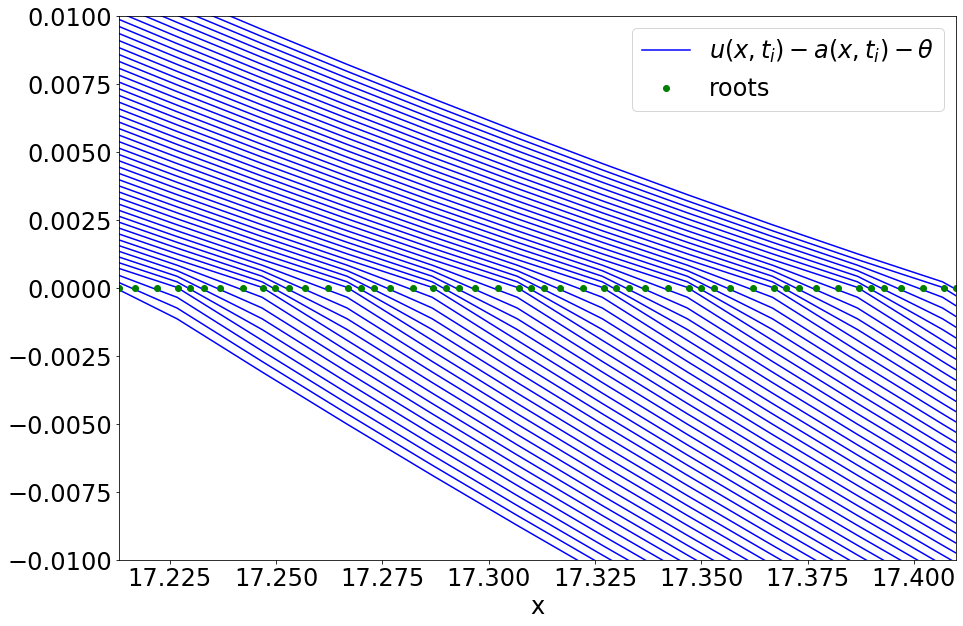

t = 4.300000
k = 0.001000
h = 0.020002


In [180]:
index = 4300

plt.figure(figsize=(15, 10))

plt.plot(0,0, 'b-', label='$u(x,t_i)-a(x,t_i)-\\theta$')
plt.plot(0,0, 'go', label='roots')

for i in range(0, 50, 1):
    plt.plot(xs, js[index+i]-θ, 'b-')
    plt.plot(fronts[index+i][1], [0], 'go')
plt.xlim(fronts[index][1], fronts[index+i][1])
plt.ylim(-.01, 0.01)
plt.xlabel('x')
plt.legend()
plt.savefig('../reports/report20210610/root_snapshots.png')
plt.show()
print('t = %f' % ts[index])
print('k = %f' % k)
print('h = %f' % h)

In [210]:
fronts[-1][0]

-11.906723493073951

In [211]:
fronts[-1][1]

20.013341279382466

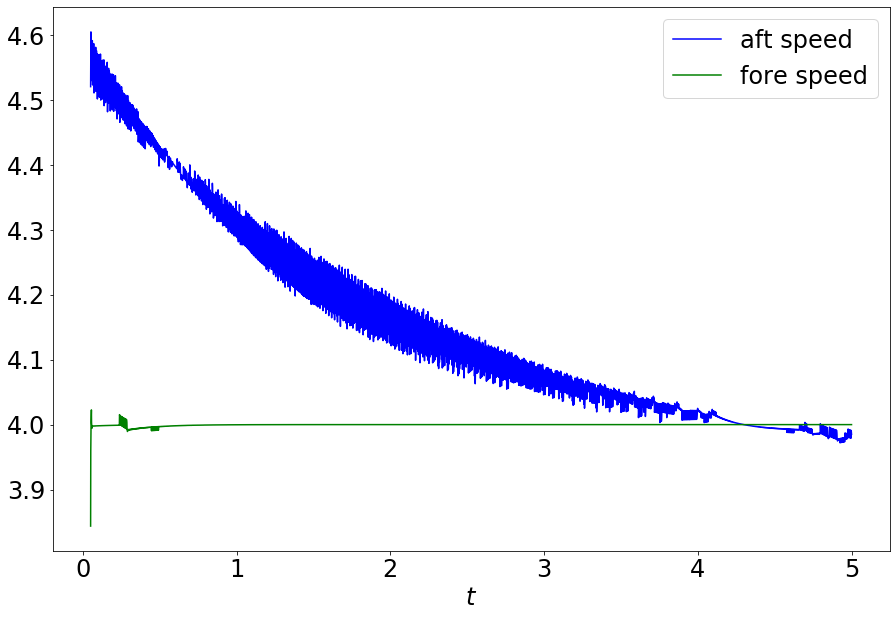

t = 4.300000
k = 0.001000
h = 0.020002


In [208]:
forefront = np.array([front[1] for front in fronts])
aftfront = np.array([front[0] for front in fronts])

index_separation = 50
speeds_back = [ (f2[0]-f1[0])/(t2-t1) for f2, f1, t2, t1 in zip(fronts[index_separation:], fronts[:-index_separation], ts[index_separation:], ts[:-index_separation]) ]
speeds_front = [ (f2[1]-f1[1])/(t2-t1) for f2, f1, t2, t1 in zip(fronts[index_separation:], fronts[:-index_separation], ts[index_separation:], ts[:-index_separation]) ]

plt.figure(figsize=(15, 10))

plt.plot(ts[index_separation:], speeds_back, 'b-', label="aft speed")
plt.plot(ts[index_separation:], speeds_front, 'g-', label="fore speed")

plt.xlabel('$t$')
plt.legend()
# plt.savefig('../reports/report20210610/front_speeds.png')
plt.show()
print('t = %f' % ts[index])
print('k = %f' % k)
print('h = %f' % h)

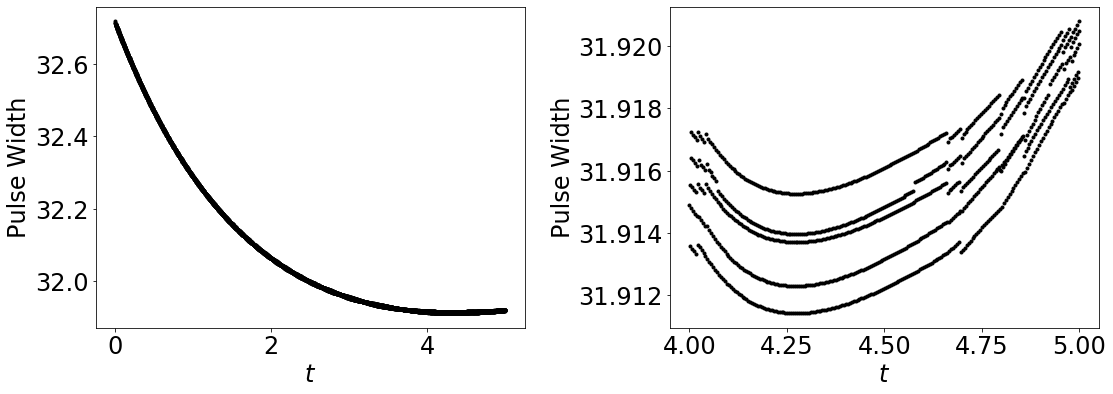

In [209]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(ts, forefront-aftfront, 'k.')
axes[1].plot(ts[4000:], [front[1]-front[0] for front in fronts[4000:]], 'k.')
for ax in axes:
    ax.set_xlabel('$t$')
    ax.set_ylabel('Pulse Width')
plt.tight_layout()
plt.savefig('../reports/report20210610/pulse_widthds.png')
plt.show()